In [1]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import custom functions
os.chdir('..')
from FLOCK_GPS import DataLoading, Preprocessing, DirectionalCorrelation


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [4]:
# get slices for movement periods and break times   
movements_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Extracting movement periods


100%|██████████| 5/5 [09:12<00:00, 110.45s/it]


Get an just one example squad's data

In [5]:
movements = movements_bySquad[1]

Get the smoothed data


In [6]:
smooth_movements = Preprocessing.spline_smoothing(movements, s=3e1, UTM=True)

Get leadership metrics

In [7]:
names = smooth_movements[0].UTM_x.columns
time_delay_dfs, HCS_ratio_dfs, graphs = DirectionalCorrelation.get_directional_corr(smooth_movements, names=names, UTM=True, window_length = 9)

100%|██████████| 7/7 [05:57<00:00, 51.07s/it]


This gives us a 'leadership score' from the average time-delay for each individual
<br>
The more positive the time-delay, the more directional influence that individual has

In [8]:
time_delay_dfs[0].mean()


Member 1 (Squad 2)    0.028342
Member 2 (Squad 2)    0.086318
Member 3 (Squad 2)   -0.098910
Member 4 (Squad 2)   -0.046654
Member 5 (Squad 2)    0.072385
Member 6 (Squad 2)   -0.068123
Member 7 (Squad 2)   -0.091568
Member 8 (Squad 2)    0.128615
dtype: float64

We also get a metric for  Highly Correlated Segments (HCS)<br>
This is the ratio of time an individual is highly correlated with other individuals while they are within proximity

In [9]:
HCS_ratio_dfs[0].mean()

Member 1 (Squad 2)    0.788374
Member 2 (Squad 2)    0.875661
Member 3 (Squad 2)    0.847850
Member 4 (Squad 2)    0.866153
Member 5 (Squad 2)    0.832689
Member 6 (Squad 2)    0.829647
Member 7 (Squad 2)    0.811997
Member 8 (Squad 2)    0.796939
dtype: float64

Plot leadership graphs for each movement period 


The Y axis location of nodes represents the time-delay (leadership score) value, while the X axis is arbitrary<br>
The edges point from leader to follower with a specific directional correlation time-delay for that pair<br>

The Quality of the heirarchy is considered the ratio of arrows pointing downards (from high leadership score to low leadership score)<br>
The number of loops should be close to zero

We mark the individual who is Squad leader with green and the platoon leaders with blue

MovieWriter ffmpeg unavailable; using Pillow instead.


animation saved to c:\Users\James\GitRepos\GPS-ruck\..\Figures\Pairwise_Leadership_AnimationSquad_2.gif


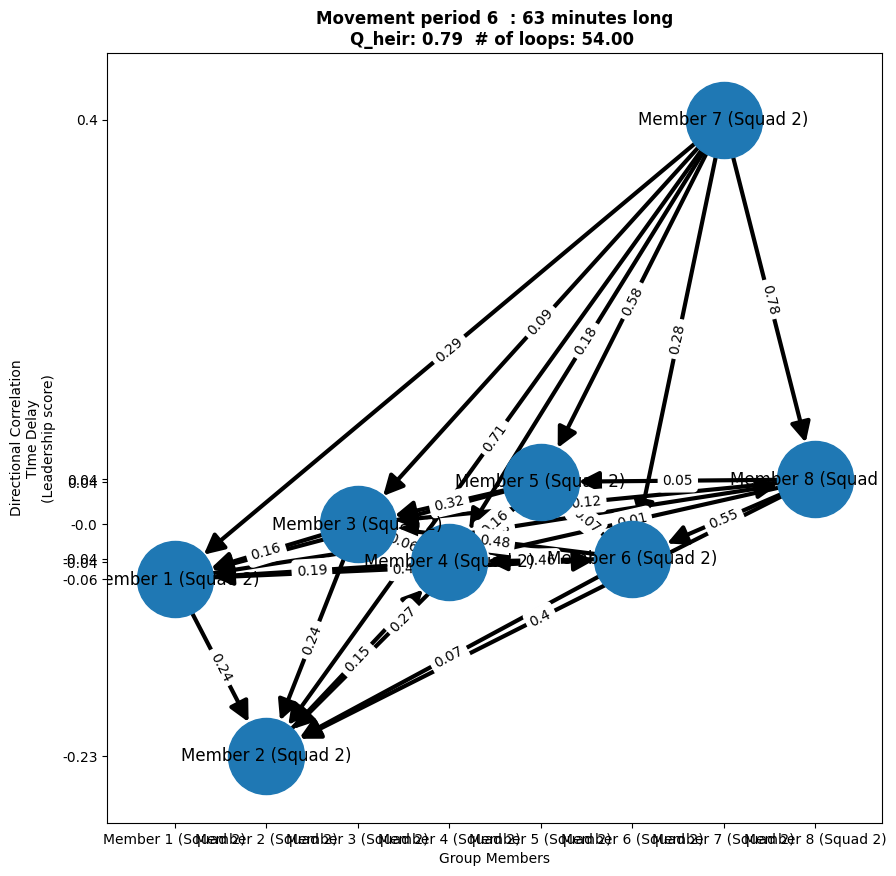

In [11]:
sq_name = smooth_movements[0].attrs['name'].split('.')[0]
DirectionalCorrelation.leadership_graph_ani(time_delay_dfs, graphs, names, sq_name, show=False)
print('animation saved to ' + os.getcwd() + r'\..\Figures\Pairwise_Leadership_Animation'+sq_name+'.gif')

Nodes represent group members <br>
Edges represent the direction of influence as well as the associated time delay <br>
Locaiton on the Y axis represents an individual's average directional correlation tiem delay <br>

<img src= '..\Figures\Pairwise_Leadership_Animation_Squad_2.gif' width='700' align='center'>

Simple simulation

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


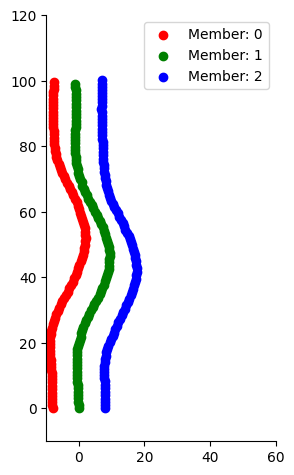

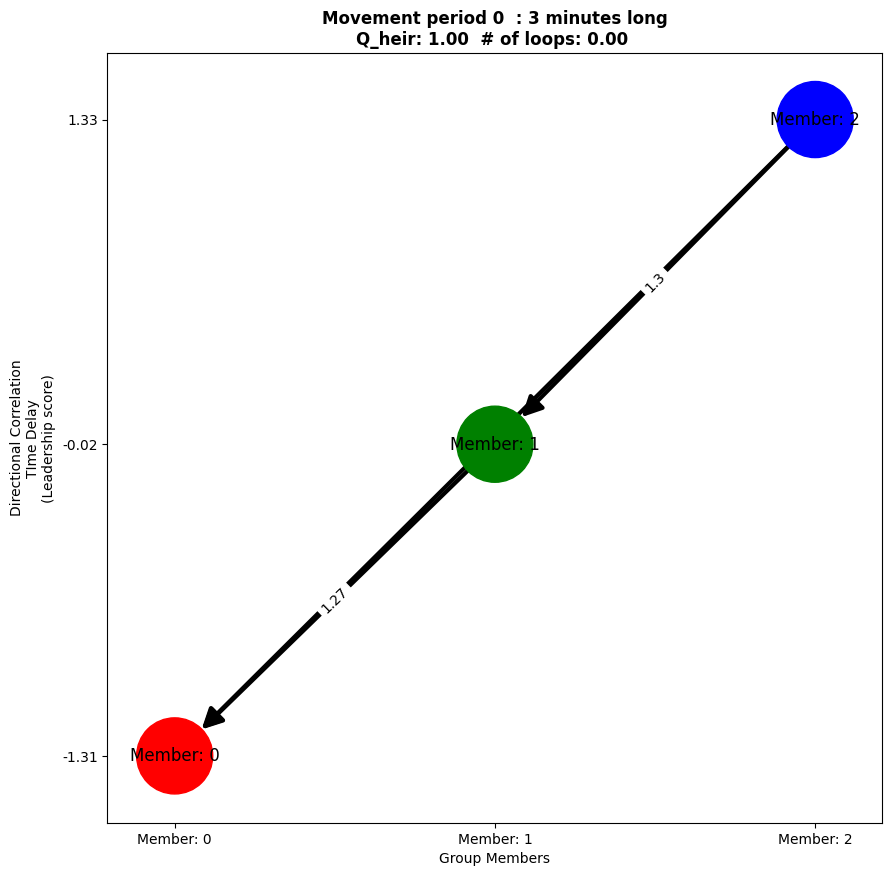

In [3]:
import random 

p1 = [[ 0, 0]]
p2 = [[ 8, 0]]
p3 = [[-8, 0]]


steps = 100

for step in range(steps):

    p1start = 15
    p2start = 10
    p3start = 20

    if step >= p1start and step < (p1start + np.pi*2*10):
        x = step - p1start
        p1extra = (np.sin(x/10))/2
    else:
        p1extra = 0 
    
    
    if step >= p2start and step < (p2start + np.pi*2*10):
        x = step - p2start
        p2extra = (np.sin(x/10))/2
    else:
        p2extra = 0 

    
    if step >= p3start and step < (p3start + np.pi*2*10):
        x = step - p3start
        p3extra = (np.sin(x/10))/2
    else:
        p3extra = 0 



    p1x = random.randint(-10,10)/100 + p1extra
    p2x = random.randint(-10,10)/100 + p2extra
    p3x = random.randint(-10,10)/100 + p3extra


    p1y = random.randint(-10,10)/100 + 1
    p2y = random.randint(-10,10)/100 + 1
    p3y = random.randint(-10,10)/100 + 1
    
    p1.append([p1[-1][0] + p1x, p1[-1][1] + p1y])
    p2.append([p2[-1][0] + p2x, p2[-1][1] + p2y])
    p3.append([p3[-1][0] + p3x, p3[-1][1] + p3y])


Pdf = pd.concat([pd.DataFrame(p, columns=pd.MultiIndex.from_tuples((('UTM_x', 'Member: '+str(s)) , ('UTM_y', 'Member: '+str(s)) ))) for s, p in enumerate ([p3,p1,p2])], axis=1)

colors = {'Member: 0':'r', 'Member: 1': 'g', 'Member: 2': 'b'}
for name in Pdf.UTM_x.columns:
    plt.scatter(Pdf.UTM_x[name], Pdf.UTM_y[name], label=name, color=colors[name])

plt.gca().set_aspect('equal')
plt.legend()
sns.despine()
plt.tight_layout()
plt.gca().set_xlim(-10, 60) 
plt.gca().set_ylim(-10, 120) 

time_delay_dfs, HCS_ratio_dfs, graphs = DirectionalCorrelation.get_directional_corr([Pdf], names=Pdf.UTM_x.columns,  UTM=True, window_length = 9)

DirectionalCorrelation.leadership_graph_ani(time_delay_dfs, graphs, names=Pdf.UTM_x.columns, sq_name='test', show=False)

(-10.0, 120.0)

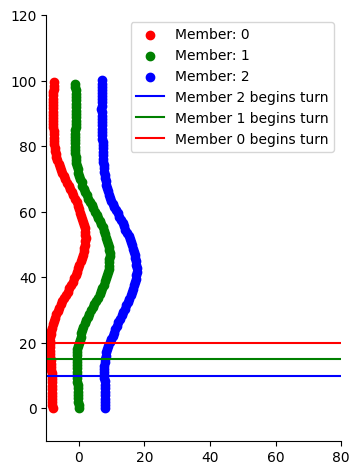

In [28]:
colors = {'Member: 0':'r', 'Member: 1': 'g', 'Member: 2': 'b'}
for name in Pdf.UTM_x.columns:
    plt.scatter(Pdf.UTM_x[name], Pdf.UTM_y[name], label=name, color=colors[name])


plt.axhline(10, color='b', label='Member 2 begins turn')
plt.axhline(15, color='g', label='Member 1 begins turn')
plt.axhline(20, color='r', label='Member 0 begins turn')

plt.gca().set_aspect('equal')
plt.legend()
sns.despine()
plt.tight_layout()
plt.gca().set_xlim(-10, 80) 
plt.gca().set_ylim(-10, 120) 

In [31]:
time_delay_dfs[0].mean(), HCS_ratio_dfs[0]

(Member: 0   -1.306122
 Member: 1   -0.016667
 Member: 2    1.326531
 dtype: float64,
    Member: 0  Member: 1  Member: 2
 0   0.795775        1.0   0.795775)